# Jupyter Tutorial for the RSS Radiance Collection

This is a collection of microwave radiometer measurements and useful ancillary data.  The goal of the collection is to make it easier for the community to develop and use algorithms based on microwave radiance measurements in their own research.

The creation of this data collection was funded by the ACCESS-2019 NASA program.  One of the elements of that program was to develop training for machine learning (ML) algorithms.  The product that we produced and are the subject of this tutorial is not a single training dataset, but rather a toolkit to facilitate other researchers to easily and accurately develop training datasets for their specific applications.  Because the microwave radiances included are sensivitive to both surface and atmospheric conditions, what might be considered a "label" for one researchers project might be considered confounding noise for another project.

The examples below ate just that, examples, of what one could do with the data collection.


### Important Features
- All measurements and ancillary data are accurately resampled onto a common, Earth-fixed grid, with a common circular footprint
- Data are organized into daily files, each of which contain 24 hourly slices.
- When appropriate, ancillary data are interpolated in time to correspond to the satellite observation time
- Metadata are CF-1.8 compliant
- Two footprint sizes are produced, 30km and 70km.  It is impossible to resample some low frequency channels to the smaller 30km footprints
- Data are available on a global equirectangular grid (regular latitude/longitude) and on the EASE2 polar grid.  The EASE2 grid data extents to within 30 degrees of the equator

### Dataset Location
Currently, the data are hosted on the RSS website, and can be downloaded using either https or ftp methods.
The https base usr is:

__https://data.remss.com/radiance/__


### Satellites included in the collection
- AMSR2, 2013-2021
- SSM/I (under development)
- SMAP (under development)

### Tutorial Organization
1. Simple download of single variables, subsetting and plotting.
2. Download of multiple variables
3. Construction example ML training dataset
4. Example of using the training dataset to train a simple regression algorithm for to retrieve surface temperature.  

First, import the necessary packages.  The rss_plotting package can be found on github: https://github.com/CarlMears/RSS_plotting

In [ ]:
import numpy as np
import xarray as xr
import requests
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pathlib import Path
from rss_plotting.global_map import plot_global_map

This is a helper function that downloads a file for a specific variable for a specified date. 

In [2]:
def retrieve_rss_radiance_var(*,
    rss_radiance_url_base : str = 'https://data.remss.com/radiance',
    year_to_get : int,
    month_to_get : int,
    day_to_get: int,
    satellite : str = 'amsr2',
    footprint_diameter : int = 30,
    var_to_get : str,
    output_path,
    verbose : bool = False):

    '''
    :param rss_radiance_url_base: base url for the https interface to the radiance collection
    :param year_to_get: year for the date to download
    :param month_to_get: month for the date to download    
    :param day_to_get: day for the date to download    
    :param satellite: sensor name
    :param footprint_diameter: footprint diameter - should be 30 or 70
    :param var_to_get: name of the variable to get
    :param output_path: path to location to write the downlaoded file
    :param verbose: set to True for more verbose reporting
    :returns: path to file that was written
    :raises HTTPError: raises an exception when the url is not found (date invalid, date out of range)
    :raises FileNotFoundError: raises an exception when output path is not valid
    '''
    # I think the above in sphinx format

    url_to_get = f'{rss_radiance_url_base}/{satellite.upper()}_{footprint_diameter}km'
    url_to_get = f'{url_to_get}/Y{year_to_get}/M{month_to_get:02d}/D{day_to_get:02d}'

    filename = f'{satellite}_{var_to_get}_{year_to_get}_{month_to_get:02d}_{day_to_get:02d}.{footprint_diameter:03d}km.nc'
    url_to_get = f'{url_to_get}/{filename}'

    if verbose:
        print(f'Retrieving: {url_to_get}')

    try:
        response = requests.get(url_to_get)
        response.raise_for_status()
    except requests.exceptions.HTTPError as err:
        print(err)
        raise err
    nc_file = open(output_path / filename, 'wb')
    nc_file.write(response.content)
    if verbose:
        print(f'Wrote: {output_path / filename}')

    return output_path / filename

Download an example dataset.  This is the surface skin temperature from ERA5.

In [3]:
output_path = Path('C:/Users/mears/jupyter_tutorials/downloads')

try:
    filename = retrieve_rss_radiance_var(
                rss_radiance_url_base = 'https://data.remss.com/radiance',
                year_to_get = 2013,
                month_to_get = 7,   
                day_to_get = 2,
                satellite = 'amsr2',
                footprint_diameter = 30,
                var_to_get = 'skt_era5',
                output_path = Path('C:/Users/mears/jupyter_tutorials/downloads'),
                verbose=True)
except Exception as err:
    print(err)
    print()



Retrieving: https://data.remss.com/radiance/AMSR2_30km/Y2013/M07/D02/amsr2_skt_era5_2013_07_02.030km.nc
Wrote: C:\Users\mears\jupyter_tutorials\downloads\amsr2_skt_era5_2013_07_02.030km.nc


Read data from the downloaded file using xarray

In [ ]:
print(f'Reading data from {filename}')

ds = xr.open_dataset(filename)
skt = ds['skt_era5'].values
lat = ds['latitude'].values
lon = ds['longitude'].values

Reading data from C:\Users\mears\jupyter_tutorials\downloads\amsr2_skt_era5_2013_07_02.030km.nc


Plot a global map of a selected time slice

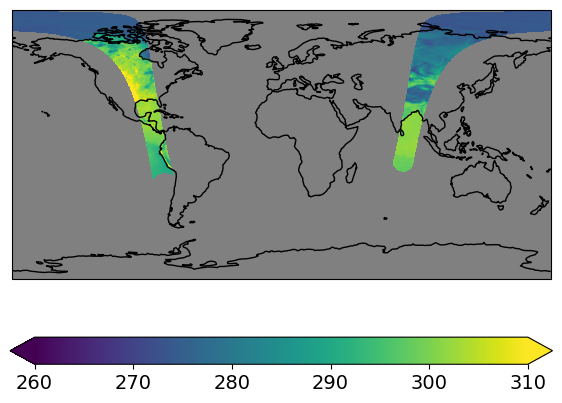

In [5]:
fig,ax = plot_global_map(skt[:,:,19],vmin=260,vmax=310,cmap='viridis',plt_colorbar=True)

Extract a geographic subset

In [6]:
#first rotate the longitudes to it plays better with cartopy

skt = np.roll(skt,720,axis=1)
lon = np.roll(lon,720)
lon[lon>180.] = lon[lon>180.] - 360.

lon_range = [-120.0,-70.0]
lat_range = [20.0,60.0]
time_index = 37

lon_ok = np.all([(lon >= lon_range[0]),(lon <= lon_range[1])],axis=0)
lat_ok = np.all([(lat >= lat_range[0]),(lat <= lat_range[1])],axis=0)

skt_subset = skt[lat_ok,:,time_index]
skt_subset = skt_subset[:,lon_ok]
shp = skt_subset.shape
num_pix_possible = shp[0]*shp[1]
print(f'Found {np.sum(np.isfinite(skt_subset))} valid pixels out of possible {num_pix_possible}')



Found 13333 valid pixels out of possible 32361


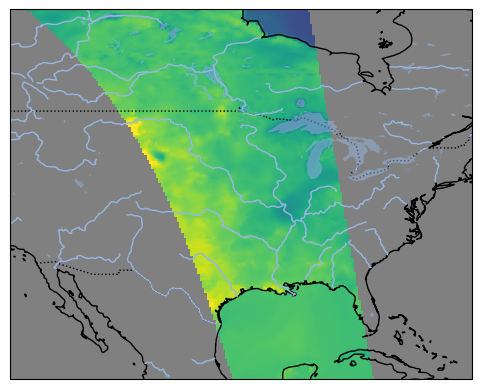

In [7]:


fig = plt.figure()
vmin = 260
vmax= 320
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([lon_range[0],lon_range[1],lat_range[0],lat_range[1]], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

cmap = 'viridis'
cmap_copy = plt.get_cmap(cmap).copy()
cmap_copy.set_bad('grey')
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

map = ax.imshow(skt_subset, cmap=cmap_copy, origin='lower', transform=ccrs.PlateCarree(),
                    norm=norm, extent=[lon_range[0],lon_range[1],lat_range[0],lat_range[1]])
    

plt.show()

### We now start assembling a simple ML training dataset

For this example, we are going create a simple training dataset that depends entirely on measured and reanalysis data.  (This might not be the best ideas because datasets based on only "real world" data tend to be insufficiently diverse.  We will discuss some ways around this limitation later in the tutorial).  

We will use the following variables for the training dataset:
- Resampled Radiances from AMSR2
- Land Fraction from MODIS, resampled to the AMSR2 footprints
- Total Column Cloud Water, from ERA5
- Total Column Water Vapor, from ERA5
- Rainfall Rate, from IMERG (used to exclude moderate to heavy rain)
--------
- Surface Skin Temperature, from ERA5, as the algorithm target
--------
In the next cell, we download all the required datasets to a local directory



In [133]:
output_path = Path('C:/Users/mears/jupyter_tutorials/downloads')

vars_to_get = ['land_frac_modis','tclw_era5','tcwv_era5','rainfall_rate','skt_era5','resamp_tbs']
vars_in_file= ['land_fraction','tclw_era5','tcwv_era5','rainfall_rate','skt_era5','brightness_temperature']

year_to_get = 2013
month_to_get = 2 
day_to_get = 2
satellite = 'amsr2'
footprint_diameter=30

filenames = {}
for var in vars_to_get:
    try:
        filename = retrieve_rss_radiance_var(
                    rss_radiance_url_base = 'https://data.remss.com/radiance',
                    year_to_get = year_to_get,
                    month_to_get = month_to_get,   
                    day_to_get = day_to_get,
                    satellite = satellite,
                    footprint_diameter = footprint_diameter,
                    var_to_get = var,
                    output_path = Path('C:/Users/mears/jupyter_tutorials/downloads'),
                    verbose=True)
        filenames[var] = filename
    except Exception as err:
        print(err)
        print()

Retrieving: https://data.remss.com/radiance/AMSR2_30km/Y2013/M02/D02/amsr2_land_frac_modis_2013_02_02.030km.nc
Wrote: C:\Users\mears\jupyter_tutorials\downloads\amsr2_land_frac_modis_2013_02_02.030km.nc
Retrieving: https://data.remss.com/radiance/AMSR2_30km/Y2013/M02/D02/amsr2_tclw_era5_2013_02_02.030km.nc
Wrote: C:\Users\mears\jupyter_tutorials\downloads\amsr2_tclw_era5_2013_02_02.030km.nc
Retrieving: https://data.remss.com/radiance/AMSR2_30km/Y2013/M02/D02/amsr2_tcwv_era5_2013_02_02.030km.nc
Wrote: C:\Users\mears\jupyter_tutorials\downloads\amsr2_tcwv_era5_2013_02_02.030km.nc
Retrieving: https://data.remss.com/radiance/AMSR2_30km/Y2013/M02/D02/amsr2_rainfall_rate_2013_02_02.030km.nc
Wrote: C:\Users\mears\jupyter_tutorials\downloads\amsr2_rainfall_rate_2013_02_02.030km.nc
Retrieving: https://data.remss.com/radiance/AMSR2_30km/Y2013/M02/D02/amsr2_skt_era5_2013_02_02.030km.nc
Wrote: C:\Users\mears\jupyter_tutorials\downloads\amsr2_skt_era5_2013_02_02.030km.nc
Retrieving: https://data.re

In this cell, we read the data from the local directory using xarray, and store the data in numpy format in a dictionary

In [134]:

vars = filenames.keys()
data_dict = {}
for ivar,var in enumerate(vars):
    filename = filenames[var]
    print(f'Reading data from {filename.name}')

    ds = xr.open_dataset(filename)
    data = ds[vars_in_file[ivar]].values
    if ivar == 0:
        lat = ds['latitude'].values
        lon = ds['longitude'].values
        data_dict['lat'] = lat
        data_dict['lon'] = lon
    data_dict[var] = data

Reading data from amsr2_land_frac_modis_2013_02_02.030km.nc
Reading data from amsr2_tclw_era5_2013_02_02.030km.nc
Reading data from amsr2_tcwv_era5_2013_02_02.030km.nc
Reading data from amsr2_rainfall_rate_2013_02_02.030km.nc
Reading data from amsr2_skt_era5_2013_02_02.030km.nc
Reading data from amsr2_resamp_tbs_2013_02_02.030km.nc


Examine the dictionary to make sure the keys make sense.

In [135]:
data_dict.keys()

dict_keys(['lat', 'lon', 'land_frac_modis', 'tclw_era5', 'tcwv_era5', 'rainfall_rate', 'skt_era5', 'resamp_tbs'])

Expand the lat and lon variables to 721 x 1440 maps.  This simplifies geographical masking.

In [136]:
latv,lonv = np.meshgrid(lat,lon,indexing='ij')
data_dict['latv'] = latv
data_dict['lonv'] = lonv

Plot a few example maps to make sure that the data make sense.

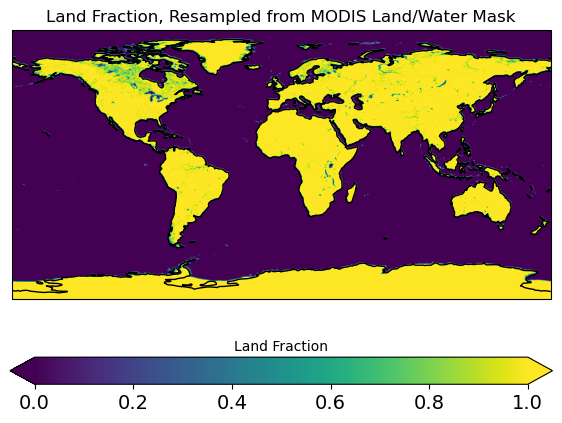

In [137]:
fig,ax = plot_global_map(data_dict['land_frac_modis'][:,:],
                         vmin=0.0,
                         vmax=1.0,
                         cmap='viridis',
                         plt_colorbar=True,
                         units='Land Fraction',
                         title='Land Fraction, Resampled from MODIS Land/Water Mask')

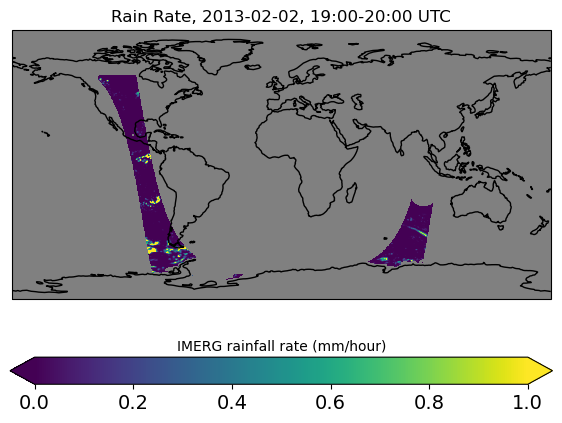

In [138]:
hour = 19
date_str = f'{year_to_get}-{month_to_get:02d}-{day_to_get:02d}, {hour:02d}:00-{hour+1:02d}:00 UTC'
fig,ax = plot_global_map(data_dict['rainfall_rate'][:,:,hour],
                         vmin=0.0,
                         vmax=1.0,
                         cmap='viridis',
                         plt_colorbar=True,
                         units = 'IMERG rainfall rate (mm/hour)',
                         title = f'Rain Rate, {date_str}')

Construct a mask that flags the data that we want to include in training dataset.  Here we are excluding rainfall rate above 0.1 mm per hour, and scenes where the land fraction is less than 0.1.  We also focus in the northern midlatitudes from 30N to 65N.

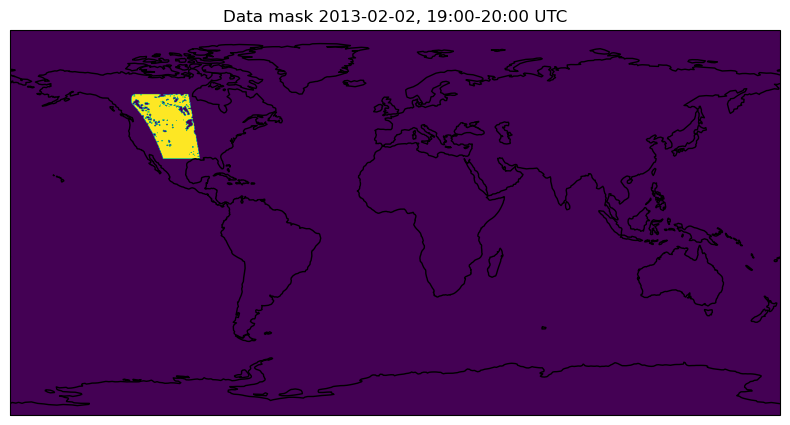

In [151]:
def make_mask(data_dict,hour):

    ok = np.all([data_dict['land_frac_modis'] > 0.8,
                data_dict['rainfall_rate'][:,:,hour] < 0.01,
                data_dict['resamp_tbs'][:,:,hour,2,1] < 310.0,
                data_dict['latv'] >= 30.0,
                data_dict['latv'] <= 65.0],axis=0)
    return ok

hour = 19
ok = make_mask(data_dict,hour)

fig,ax = plot_global_map(ok,
                         vmin=0.0,
                         vmax=1.0,
                         cmap='viridis',
                         title=f'Data mask {date_str}')

Loop over the 24 hours in the day, keeping the masked data in each time slice

(129645,)
(129645,)
(129645,)
(129645,)


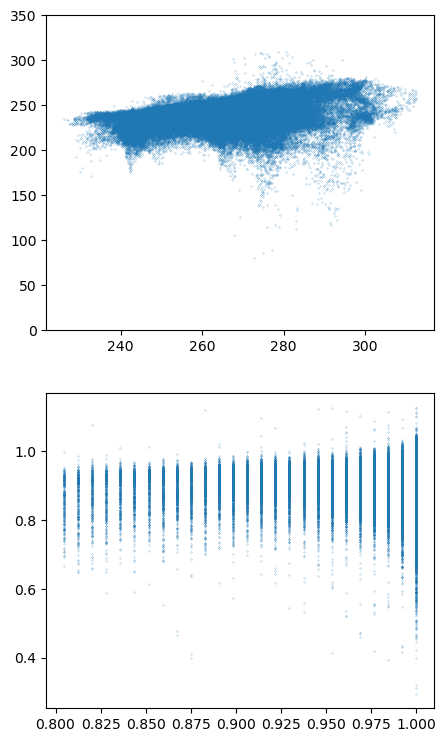

In [152]:
lf = []
tclw = []
tcwv = []
tb11v = []
tb11h = []
tb19v = []
tb19h = []
tb24v = []
tb24h = []
tb37v = []
tb37h = []
skt = []
rr=[]
for hour in range(0,24):
    ok = make_mask(data_dict,hour)

    lf = np.append(lf, data_dict['land_frac_modis'][ok])
    tclw= np.append(tclw, data_dict['tclw_era5'][:,:,hour][ok])
    tcwv= np.append(tcwv, data_dict['tcwv_era5'][:,:,hour][ok])
    
    tb11v= np.append(tb11v, data_dict['resamp_tbs'][:,:,hour,2,0][ok])
    tb11h= np.append(tb11h, data_dict['resamp_tbs'][:,:,hour,2,1][ok])

    tb19v= np.append(tb19v, data_dict['resamp_tbs'][:,:,hour,3,0][ok])
    tb19h= np.append(tb19h, data_dict['resamp_tbs'][:,:,hour,3,1][ok])

    tb24v= np.append(tb24v, data_dict['resamp_tbs'][:,:,hour,4,0][ok])
    tb24h= np.append(tb24h, data_dict['resamp_tbs'][:,:,hour,4,1][ok])

    tb37v= np.append(tb37v, data_dict['resamp_tbs'][:,:,hour,5,0][ok])
    tb37h= np.append(tb37h, data_dict['resamp_tbs'][:,:,hour,5,1][ok])

    skt= np.append(skt, data_dict['skt_era5'][:,:,hour][ok])
    rr= np.append(rr,data_dict['rainfall_rate'][:,:,hour][ok])

print(lf.shape)
print(skt.shape)
print(tb11v.shape)
print(tb19v.shape)

fig,axs = plt.subplots(nrows=2,figsize=(5,9))

axs[0].scatter(skt,tb11h,marker='.',s=0.1)
axs[0].set_ylim([0,350])
axs[1].scatter(lf,tb11h/skt,marker='.',s=0.1)


plt.show()




    

[ 0.25149334  0.05045685  0.38598437 -1.12633098  0.3265263   1.08567135
 -0.06638739 -0.05027754  8.13536767]


c:\Users\mears\miniconda3\envs\jupyter_tutorials\Lib\site-packages\matplotlib\axes\_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


{'num': 126482.0, 'mean': -0.1314046541063597, 'rms': 5.6100229550547045, 'stddev': 5.608505956786894}
{'num': 126482.0, 'mean': -0.16007967852877017, 'rms': 5.422272933058161, 'stddev': 5.419930858297552}


(<Figure size 1000x800 with 1 Axes>, <Axes: ylabel='Number of Observations'>)

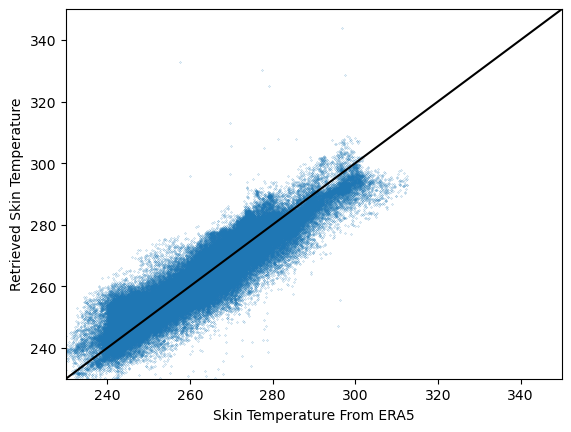

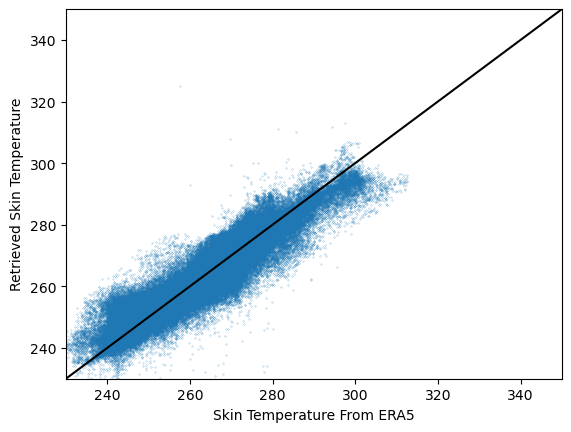

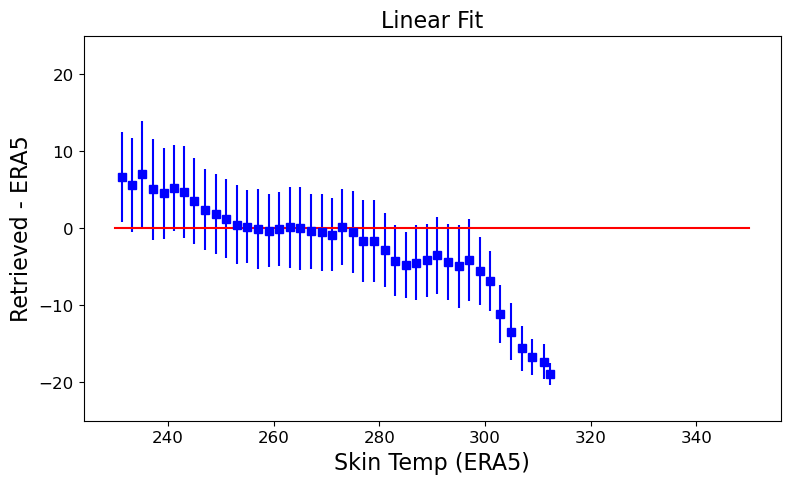

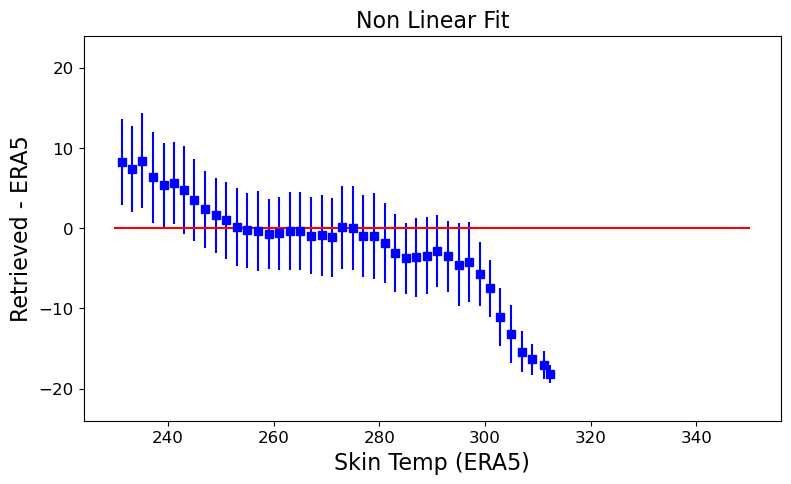

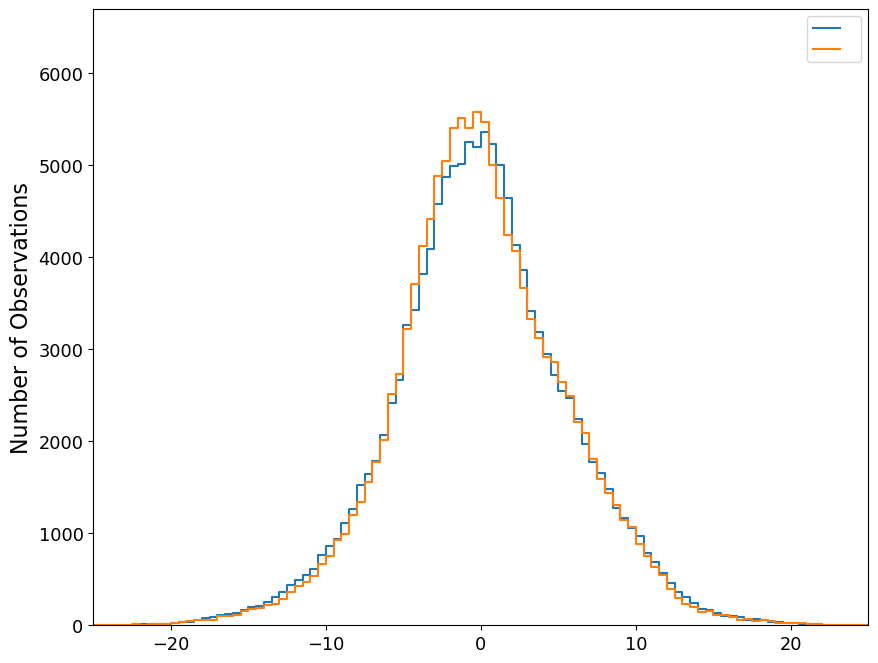

In [153]:
from sklearn import linear_model
from sklearn.svm import SVR
from rss_stats.binned_stats import BinnedStat
from rss_stats.hist_1d import Hist1D


reg = linear_model.LinearRegression()

bs_lin = BinnedStat(num_bins=60,x_rng=[230,350])
hist = Hist1D(min_xval=-25,max_xval=25,num_xbins=100,name='lin')
hist.add_data_var(name='quad')


bs_quad = BinnedStat(num_bins=60,x_rng=[230,350])
hist1d_quad = Hist1D(num_xbins=100,min_xval=-25,max_xval=25)

X1 = np.transpose([tb11v,tb11h,tb19v,tb19h,tb24v,tb24h,tb37v,tb37h,lf])
X2 = np.transpose([tb11v,tb11h,tb19v,tb19h,tb24v,tb24h,tb37v,tb37h,tb11h/tb11v,tb11h/tb37h])
y = skt

lin_fit = reg.fit(X1,y)
lin_vals = lin_fit.predict(X1)
print(reg.coef_)

quad_fit = reg.fit(X2,y)
quad_vals = quad_fit.predict(X2)


fig,ax = plt.subplots()
ax.scatter(skt,lin_vals,s=0.1,marker='.')
ax.set_xlim(230,350)
ax.set_ylim(230,350)

ax.set_xlabel('Skin Temperature From ERA5')
ax.set_ylabel('Retrieved Skin Temperature')

ax.plot([230,350],[230,350],color='black')

fig,ax = plt.subplots()
ax.scatter(skt,quad_vals,s=0.1,marker='.')
ax.set_xlabel('Skin Temperature From ERA5')
ax.set_ylabel('Retrieved Skin Temperature')
ax.set_xlim(230,350)
ax.set_ylim(230,350)
ax.plot([230,350],[230,350],color='black')

bs_lin.add_data(skt,lin_vals-skt)
bs_lin.plot(xlab='Skin Temp (ERA5)',ylab='Retrieved - ERA5',title='Linear Fit')

stats = bs_lin.calc_stats_over_range(xrange=[240,315])
print(stats)

bs_quad.add_data(skt,quad_vals-skt)
bs_quad.plot(xlab='Skin Temp (ERA5)',ylab='Retrieved - ERA5',title='Non Linear Fit')
stats = bs_quad.calc_stats_over_range(xrange=[240,315])
print(stats)
hist.add_data(lin_vals-skt,name='lin')
hist.add_data(quad_vals-skt,name='quad')

fig,ax = hist.plot(name='lin')
hist.plot(fig=fig,ax=ax,name='quad',plt_legend=True)




340.8230895996094
154.08156127929686
